In [11]:
pip install networkx matplotlib numpy scikit-learn qiskit-optimization gurobipy cplex docplex pennylane --quiet

In [ ]:
pip install qiskit==1.4.2

# Sampling
The MaxCut problem instances utilized in this analysis are sourced from the [HamLib](https://portal.nersc.gov/cfs/m888/dcamps/hamlib/) library. This collection encompasses a diverse range of graph topologies, including circulant graphs, bipartite graphs, $G_{n,p}$ random graphs, regular graphs and star graphs.

In [3]:
import zipfile
import requests
from io import BytesIO
import h5py
import networkx as nx
import numpy as np

url_circ = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-circulant.zip'
url_bipart = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-complete_bipart.zip'

url_gnp_k2 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-gnp_k-2.zip'
url_gnp_k3 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-gnp_k-3.zip'
url_gnp_k4 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-gnp_k-4.zip'
url_gnp_k5 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-gnp_k-5.zip'

url_reg_3 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-regular_reg-3.zip'
url_reg_4 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-regular_reg-4.zip'
url_reg_5 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-regular_reg-5.zip'
url_reg_6 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-regular_reg-6.zip'

url_star = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-star.zip'

url = [url_circ, url_bipart, url_gnp_k2, url_gnp_k3, url_gnp_k4, url_gnp_k5, url_reg_3, url_reg_4, url_reg_5, url_reg_6, url_star]

## Sampling single graph type


In [4]:
import random

all_sampled_graphs = []

sampled_graphs = []
r = requests.get(url[0], stream=True)           # choose graph type here
z = zipfile.ZipFile(BytesIO(r.content))
hdf5_filename = z.namelist()[0]
z.extract(hdf5_filename)

with h5py.File(hdf5_filename, 'r') as f:
    dataset_keys = list(f.keys())
    num_datasets = len(dataset_keys)

    random_indices = random.sample(range(num_datasets), 5)

    for index in random_indices:
        graph = nx.Graph(list(np.array(f[dataset_keys[index]])))

        if graph.number_of_nodes() <= 2500 and graph.number_of_nodes() >= 10:
            sampled_graphs.append(graph)

all_sampled_graphs.append(sampled_graphs)
all_sampled_graphs = all_sampled_graphs[0]

# Classical Solvers WITHOUT Partitioning

In [5]:
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import GurobiOptimizer
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer
from qiskit_optimization.algorithms import CplexOptimizer
import numpy as np
import networkx as nx


def classical_solvers_without_partitioning(graph):
    A = nx.to_numpy_array(graph)
    max_cut = Maxcut(A)
    qp = max_cut.to_quadratic_program()

    optimizer = GoemansWilliamsonOptimizer(2)
    gw_result = optimizer.solve(qp)
    gw_cut_edges = 0
    for u, v in graph.edges():
        if gw_result.x[u] != gw_result.x[v]:
            gw_cut_edges += 1
    print("GW Done")

    #nx_cut_size, partition = nx.approximation.one_exchange(graph, seed=1)
    #print("Nx Done")

    #optimizer = CplexOptimizer()
    #cplex_result = optimizer.solve(qp)
    #cplex_cut_edges = 0
    #for u, v in graph.edges():
    #    if cplex_result.x[u] != cplex_result.x[v]:
    #        cplex_cut_edges += 1
    #print("Cplex Done")

    #optimizer = GurobiOptimizer() if GurobiOptimizer.is_gurobi_installed() else None
    #gurobi_result = optimizer.solve(qp)
    #gurobi_cut_edges = 0
    #for u, v in graph.edges():
    #    if gurobi_result.x[u] != gurobi_result.x[v]:
    #        gurobi_cut_edges += 1
    #print("Gurobi Done")
    gurobi_cut_edges, cplex_cut_edges, nx_cut_size = 0, 0, 0

    return gurobi_cut_edges, gw_cut_edges, cplex_cut_edges, nx_cut_size

# Quantum Solver WITH Partitioning
The following code segment implements a strategy to tackle the MaxCut problem on potentially large constraint graphs. It begins by partitioning the original graph into smaller, more manageable subgraphs. Subsequently, for each of these subgraphs, it employs the Quantum Approximate Optimization Algorithm (QAOA) solver, using the PennyLane simulator as the quantum computational backend.

In [6]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa

from sklearn.cluster import SpectralClustering
import networkx as nx

def run_qaoa(graph, index_map):

    # problem set up
    cost, mixer = qaoa.maxcut(graph)

    if graph.number_of_edges() == 0:

        # If no edges, create cost Hamiltonian with RZ gates
        num_qubits = len(index_map)
        cost = qml.Hamiltonian(
            [-1.0] * num_qubits,
            [qml.PauliZ(i) for i in range(num_qubits)]  # RZ gates on each qubit
        )

    wires = list(index_map.values())
    depth = 2
    params = 0.01 * np.random.rand(2, depth)
    params = np.array(params, requires_grad=True)

    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost)
        qaoa.mixer_layer(alpha, mixer)

    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, depth, params[0], params[1])

    dev = qml.device("default.qubit", wires=wires)

    # optimise
    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost)

    optimizer = qml.AdagradOptimizer(stepsize=0.5)
    steps = 30

    for i in range(steps):
        params = optimizer.step(cost_function, params)

    # find probabilities of optimal params
    @qml.qnode(dev)
    def probability_circuit(gamma, alpha):
        circuit(params)
        return qml.probs(wires=wires)

    # compute optimal 1) evaluation value 2) probability distribtuion
    eval = cost_function(params)
    probs = probability_circuit(params[0], params[1])

    def int_to_binary(n):
        return bin(n)[2:]
    max_index = qml.numpy.argmax(probs)
    max_index_int = int(max_index)
    bit_representation = int_to_binary(max_index_int).zfill(len(wires))

    return bit_representation, eval


def cluster_graph(graph: nx.Graph, avg_partition_size=6.5) -> list[nx.Graph]:

    subgraphs = []
    n = len(graph.nodes())
    total_edges = 0
    no_of_clusters = int(n / avg_partition_size)

    if no_of_clusters < 1:
        no_of_clusters = 1
    adj_matrix = nx.to_numpy_array(graph)

    sc = SpectralClustering(n_clusters=no_of_clusters, affinity='precomputed')
    partition = sc.fit_predict(adj_matrix)

    for i in range(no_of_clusters):
        subgraph = graph.subgraph([node for node, cluster in enumerate(partition) if cluster == i])
        total_edges += subgraph.number_of_edges()
        subgraphs.append(subgraph)
        print(subgraph.nodes())

    #print(f"ATTENTION: Total edges are fewer than the original graph {total_edges}")
    edges_after_pruning = total_edges / graph.number_of_edges()

    return subgraphs, edges_after_pruning

def quantum_solver_with_partitioning(graph):
    target_sizes = [6, 10, 14]
    cut_sizes = []
    edges_after_pruning = []
    for target_size in target_sizes:
        partitioning = cluster_graph(graph, target_size)
        #print(partitioning)
        subgraphs = partitioning[0]
        edges_after_pruning.append(partitioning[1])
        num_nodes = graph.number_of_nodes()
        solutions = [0] * num_nodes
        for each in subgraphs:
            index_map = {node: idx for idx, node in enumerate(each.nodes())}
            subgraph = nx.relabel_nodes(each, index_map)
            result = run_qaoa(subgraph, index_map)
            probs = result[0]
            eval = result[1]
            print(probs)
            for node in each.nodes():
                index = index_map[node]
                if solutions[node] is None:
                    solutions[node] = int(probs[index])
                else:
                    count_0 = solutions.count(0)
                    count_1 = solutions.count(1)
                    if (count_0 > count_1 and solutions[node] == 0) or \
                      (count_1 > count_0 and solutions[node] == 1) or \
                      (count_0 == count_1):
                        solutions[node] = int(probs[index])

        cut_edges = 0
        for u, v in graph.edges():
            if solutions[u] != solutions[v]:
                cut_edges += 1
        cut_sizes.append(cut_edges)

    return cut_sizes, edges_after_pruning

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:
# Run to collect the results
                              # Uses PennyLane Sim and will take long!

results = {
    'problem_size': [],
    'gurobi_cut_sizes': [],
    'gw_cut_sizes': [],
    'cplex_cut_sizes': [],
    'part_QAOA_cut_sizes': [[], [], []],
    'edges_after_pruning': [[], [], []]
}
counter = 0
for graph in all_sampled_graphs:
    qw = quantum_solver_with_partitioning(graph)
    cwo = classical_solvers_without_partitioning(graph)
    results['problem_size'].append(graph.number_of_nodes())
    results['gurobi_cut_sizes'].append(cwo[0])
    results['gw_cut_sizes'].append(cwo[1])
    results['cplex_cut_sizes'].append(cwo[2])
    for i in range(3):
        results['part_QAOA_cut_sizes'][i].append(qw[0][i])
        results['edges_after_pruning'][i].append(qw[1][i])
    counter += 1
    print(counter)

## Comparison: Partitioned QAOA vs. Unpartitioned Classical Solvers

The subsequent code block undertakes a comparative analysis of the MaxCut solution quality, specifically the size of the cut obtained through two distinct approaches:

1.  **Partitioned Quantum Approximate Optimization Algorithm (QAOA):** The original constraint graph is divided into smaller subgraphs. The MaxCut problem for each subgraph is then approximately solved using the QAOA algorithm, executed on a quantum simulator (likely PennyLane, as mentioned previously). This process is repeated for graph partitions corresponding to three different qubit sizes, allowing for an assessment of how the scale of the quantum computation within each subgraph impacts the overall result.

2.  **Unpartitioned Classical Solvers:** The MaxCut problem for the *entire* original graph is solved directly using classical optimization solvers. The code explicitly mentions gurobi, cplex and gw as classical solvers. Gurobi and CPLEX are commercial optimization solvers known for their efficiency in tackling mixed-integer programming problems, including MaxCut. GW refers to the Goemans-Williamson semidefinite programming relaxation-based approximation algorithm, which provides a theoretical guarantee on the approximation ratio.

The primary goal of this comparison is to evaluate the trade-offs between these two strategies. The partitioned QAOA approach explores the potential benefits of leveraging near-term quantum algorithms on smaller subproblems, while the unpartitioned classical solvers represent the performance achievable with state-of-the-art classical optimization techniques on the full problem instance. By comparing the resulting cut sizes, we can gain insights into the effectiveness of the partitioned QAOA approach relative to established classical methods for the MaxCut problem.

# Data/Plot included in Paper

## Large-Scale Partitioned QAOA vs. Goemans-Williamson (GW) for Circulant Graphs

Due to the computational demands of simulating the Quantum Approximate Optimization Algorithm (QAOA) on PennyLane Simulator, even when applied to partitioned subgraphs, the process was time-intensive.

To address this, the computations for the partitioned QAOA were executed in parallel, and the aggregated results are presented here specifically for circulant graph instances.

The performance of this parallelized, partitioned QAOA is then compared against the results obtained using the Goemans-Williamson (GW) algorithm. The focus here is to assess the quality of the solutions obtained by the large-scale, parallelized partitioned QAOA in comparison to the theoretically grounded and practically effective GW algorithm on circulant graphs.

In [8]:
results = {'problem_size': [300, 500, 600, 800, 900], 'gurobi_cut_sizes': [0,0, 0,0,0], 'gw_cut_sizes': [422, 706, 1182, 1134, 1782],
          'cplex_cut_sizes': [0, 0, 0, 0, 0], 'part_QAOA_cut_sizes': [[410, 692, 1008, 1084, 1512], [422, 710, 1088, 1130, 1600], [432, 720, 1120, 1162, 1656]],
          'edges_after_pruning': [[0.75, 0.747, 0.6633333333333333,  0.749375, 0.6655555555555556],
           [0.85, 0.85, 0.7933333333333333, 0.85, 0.8],
           [0.895, 0.895, 0.86, 0.890625, 0.8577777777777778]]}

In [9]:
import pandas as pd
import numpy as np

x = results['problem_size']
y_gurobi = results['gurobi_cut_sizes']
y_gw = results['gw_cut_sizes']
y_cplex = results['cplex_cut_sizes']

y_qaoa_small = []
for i in range(len(results['part_QAOA_cut_sizes'][0])):
    y_qaoa_small.append(results['part_QAOA_cut_sizes'][0][i])
y_qaoa_small = np.array(y_qaoa_small)
y_qaoa_mid = []
for i in range(len(results['part_QAOA_cut_sizes'][0])):
    y_qaoa_mid.append(results['part_QAOA_cut_sizes'][1][i])
y_qaoa_mid = np.array(y_qaoa_mid)
y_qaoa_large = []
for i in range(len(results['part_QAOA_cut_sizes'][0])):
    y_qaoa_large.append(results['part_QAOA_cut_sizes'][2][i])
y_qaoa_large = np.array(y_qaoa_large)

y_edges_small = []
for i in range(len(results['edges_after_pruning'][0])):
    y_edges_small.append(results['edges_after_pruning'][0][i])
y_edges_small = np.array(y_edges_small)

y_edges_mid = []
for i in range(len(results['edges_after_pruning'][1])):
    y_edges_mid.append(results['edges_after_pruning'][1][i])
y_edges_mid = np.array(y_edges_mid)

y_edges_large = []
for i in range(len(results['edges_after_pruning'][2])):
    y_edges_large.append(results['edges_after_pruning'][2][i])
y_edges_large = np.array(y_edges_large)

df = pd.DataFrame({
    'Problem Size': x,
    'Gurobi Cut Sizes': y_gurobi,
    'GW Cut Sizes': y_gw,
    'CPLEX Cut Sizes': y_cplex,
    'QAOA Small Cut Sizes': y_qaoa_small,
    'QAOA Mid Cut Sizes': y_qaoa_mid,
    'QAOA Large Cut Sizes': y_qaoa_large,
    'Edges Small': y_edges_small,
    'Edges Mid': y_edges_mid,
    'Edges Large': y_edges_large
})

df_sorted = df.sort_values(by='Problem Size')
#df_sorted = df_sorted[df_sorted['Problem Size'] < 75]

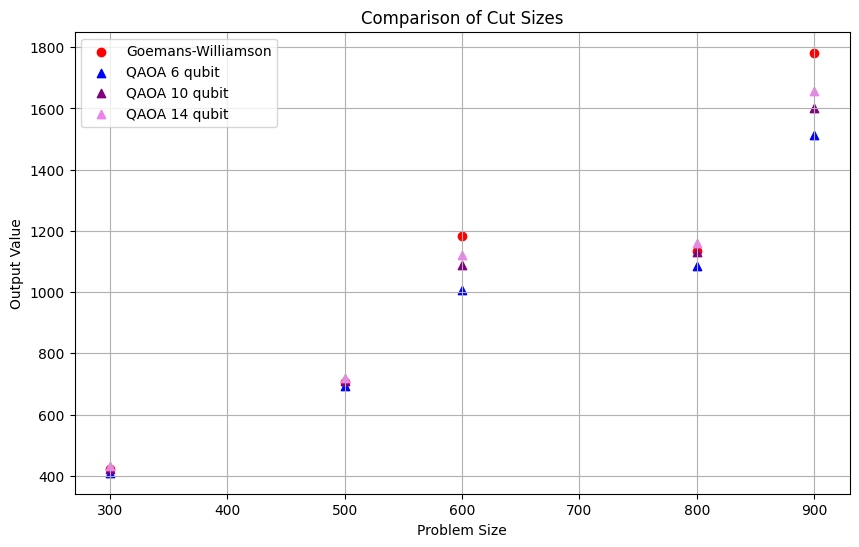

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(df_sorted['Problem Size'], df_sorted['GW Cut Sizes'], label='Goemans-Williamson', marker='o', color='red')

plt.scatter(df_sorted['Problem Size'], df_sorted['QAOA Small Cut Sizes'], label='QAOA 6 qubit', marker='^', color='blue')
plt.scatter(df_sorted['Problem Size'], df_sorted['QAOA Mid Cut Sizes'], label='QAOA 10 qubit', marker='^', color='purple')
plt.scatter(df_sorted['Problem Size'], df_sorted['QAOA Large Cut Sizes'], label='QAOA 14 qubit', marker='^', color='violet')


plt.xlabel('Problem Size')
plt.ylabel('Output Value')
plt.title('Comparison of Cut Sizes')
plt.legend()
plt.grid(True)